In [95]:
#----------------------------------------------------------------------------
# Project     : Price Alarm System Enhancement - Alarm 1 + 2 - Abnormal Price Detection
# Created By  : Eungi Cho
# Created Date: 07/06/22
# Updated Date: 23/06/22
# version ='Final'
# ---------------------------------------------------------------------------

'''
Import pandas, numpy, matplotlib to analyze data
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

'''
Import warnings module to ignore the future warning messages
'''
import warnings
warnings.filterwarnings("ignore")

'''
Import KNNImputer module to impute missing values
'''
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


'''
import time measurement module to track the progress
'''
from tqdm import tqdm
tqdm.pandas()

In [96]:
'''
Load data from provided csv file
'''
df_raw = pd.read_csv('/Users/cho-eungi/Practice/CSV/market_entry_price.csv')
df_raw = df_raw.drop_duplicates()
df_raw.head()

,source_id,country,market_id,product_id,entry_id,currency,final_unit,date,price_min,price_max,price_avg
0,16,China,2344,125,118227410,CNY,kg,2022-02-21,8.16,8.34,8.205000
1,16,China,2344,125,118227410,CNY,kg,2022-05-23,6.02,6.30,6.146667
2,16,China,2344,125,118227410,CNY,kg,2022-04-04,6.67,7.04,6.901667
3,16,China,2344,125,118227410,CNY,kg,2022-05-09,5.93,6.30,6.098000
4,16,China,2344,125,118227410,CNY,kg,2022-05-16,6.02,6.12,6.070000


# Data Pre-processsing
Step1: Randomly sampling 10000 entries to create 'sample_entry' (pd.DataFrame)

Step2: Join 'time_df' to each 'sample_entry', and make 'df' to reflect the actual frequency of price acquisition (W-MON)

Step3: Use KNN imputer to impute the null value of 'df', and update 'df'

In [97]:
'''
Randomly select 10,000 entries from df_raw to reduce processing time
'''

entry_lst = np.sort(df_raw['entry_id'].unique())
np.random.seed(0)
sample_entry = list(np.random.choice(entry_lst, 2))
sample_entry.extend([50895935])
'''
Sort df_raw by values ['entry_id', 'date'] and name it as 'sample_df'  
'''
sample_df = df_raw.loc[df_raw['entry_id'].isin(sample_entry)].sort_values(
    by = ['entry_id', 'date']).copy()

'''
Change dtype of column 'date' to pd.Timestamp
'''
sample_df['date'] = pd.to_datetime(sample_df['date'])

In [98]:
# W-MON date range from 2020 to 2022
# Left Join Test DF and Time DF
'''
*** IMPORTANT ***
df_raw has the CHARACTERISTICS as below:
1) Frequency of price acquisition is every Monday (W-MON)
2) Column 'date' is a series of 'acquired dates'
   , that means it doesn't contain 'not acquired dates'.

Therefore, it needs a process to contain 'not acquired dates' in df_raw as well, 
for reflecting the 'actual' acquisition frequency by each entry.
'''

'''
Create empty dataframe first.
'''
empty_df = pd.DataFrame()
for entry in tqdm(sample_entry):
    '''
    Step 1: Find the first acquisition date (entry_start) by each entry
            , and create date timeseries range from {entry_start} to '2022-06-20'.
            ('2022-06-20' is used only for analysis)
    '''
    entry_start = min(sample_df.loc[sample_df['entry_id'] == entry]['date'])
    date_range = pd.date_range(entry_start, '2022-06-06', freq = 'W-MON')
    
    '''
    Step 2: Create 'time_df', and attach one column 'entry_id_'.
    '''
    time_df = pd.DataFrame({'date': date_range})
    time_df['entry_id_'] = entry
    
    '''
    Step 3: Left join 'time_df' to create 'joined_df', and append it to the 'empty_df'.
    '''
    entry_df = sample_df.loc[sample_df['entry_id'] == entry]
    joined_df = pd.merge(time_df, entry_df, left_on = ['date'], right_on = ['date'], how = 'left')
    empty_df = empty_df.append(joined_df)

empty_df = empty_df.drop(['entry_id'], axis = 1)

'''
Copy the result (empty_df) as 'df'
'''
df = empty_df.copy()
df = df.sort_values(by = ['entry_id_', 'date'])
df.set_index(np.arange(len(df)), inplace=True)
df.head()

100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.02it/s]


,date,entry_id_,source_id,country,market_id,product_id,currency,final_unit,price_min,price_max,price_avg
0,2020-02-03,47440173,257.0,South Africa,589.0,99.0,ZAR,kg,380.0,380.0,380.0
1,2020-02-10,47440173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-17,47440173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-24,47440173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-02,47440173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
def knn_impute_price(Series):
    '''
    The function is defined to impute the null values of price_avg.
    
    Two features are used when doing imputation:
    1) price acquisition date (column 'date' in df)
    2) price avg (column 'price_avg' in df)
    
    The function is used in 'groupby' method, to add results to the column as below:
        df['columnA'] = df.groupby('columnB').apply(knn_impute_price).
    
    Return: 
        imputed prices series by each entry_id
    '''
    
    imputer = KNNImputer(n_neighbors = 2)
    
    '''
    imputed: dtype = ndarray
    columns: 1st column = date, 2nd column = price_avg_imputed
    '''
    imputed = imputer.fit_transform(Series)[:, 1]
    imputed_price_series = pd.Series(imputed, index = Series.index)
    return imputed_price_series

'''
Change column 'date' dtype to category, and save it to new column 'date_category'
'''
df['date_category'] = df['date'].astype('category').cat.codes

'''
Add new column 'price_avg_imputed' as a result of knn_impute_price.

ref:
    groupby method here returns series with multiple index. 
    So drop one of them ('entry_id_') for matching the index with index of the df.
'''

df['price_avg_imputed'] = df.groupby(by = 'entry_id_').progress_apply(
    lambda df: knn_impute_price(df[['date_category', 'price_avg']])
).reset_index().set_index('level_1').drop('entry_id_', axis=1)

100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 49.29it/s]


In [100]:
'''
df_stats contains only essential features from df.
'''
df_stats = df[['date', 'entry_id_', 'price_avg', 'price_avg_imputed']].copy()
df_stats_pivot = df_stats.pivot_table(['price_avg', 'price_avg_imputed']
                          , index = ['entry_id_'], columns = ['date']
                          , dropna = False)

In [101]:
def abnormalDetection_by_entry(df_pivot, entry_id, sigma=3, display_plot = False):
    sample_entry = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    '''
    Use MinMaxScaler to adjust the 'price_avg' & 'price_avg_imputed'
    '''
    scaler = MinMaxScaler()
    df_to_scale = sample_entry[['price_avg', 'price_avg_imputed']]
    scaler.fit(df_to_scale)
    
    '''
    Make df_scaled based on scaled 'price_avg', 'price_avg_imputed', with setting index as 'date'
    '''
    scaled = scaler.transform(df_to_scale) # np.ndarray
    df_scaled = pd.DataFrame(scaled, columns = df_to_scale.columns)
    df_scaled = pd.concat([df_scaled, sample_entry['date']], axis = 1)
    df_scaled.set_index('date', inplace=True)
    
    '''
    Calculate upper band and lower band, and get columns 'upper_band' & 'lower_band'
    Use past 6 months price data, and caculate the bands based on the sigma analysis.
    '''
    
    '''
    Use 'price_avg_imputed' to Calculate bands
    But index of df_scaled ranges from '2020-01-06 ~ 2022-06-06' (it may change),
    so the column 'price_avg_imputed' has values from its first reported day.
    
    Therefore, we should exclude the null values from the 'price_avg_imputed',
    while maintaining the index of the df_scaled.
    '''
    not_null_series = df_scaled['price_avg_imputed'][~np.isnan(df_scaled['price_avg_imputed'].values)]
    
    
    i, start, window_size = 0, 0, 8
    moving_average, upper_band, lower_band = [], [], []
    
    '''
    Suppose that 'not_null_series' has n rows.
    and window_size = k.
    Then, it will get number of (n - k + 1) results when calculating some statistics with moving window.
    '''
    while i < len(not_null_series) - window_size + 1:
        '''
        Set Max range as 6 month.
        e.g.
        IF         not_null_series.index[start] = 2020.01.06,
        AND        not_null_series.index[i + window_size - 1] = 2020.07.13,
        B.C.       (2020.07.13 - 2020.01.06) > 6 months,
        THEREFORE  start += 1 to make not_null_series.index[start] = 2020.01.13
        '''
        if (not_null_series.index[i + window_size - 1] - not_null_series.index[start]) / np.timedelta64(1, 'M') > 6:
            start += 1
                
        window = not_null_series[start : i + window_size]
        upper = sigma * window.std() + window.mean()
        lower = -sigma * window.std() + window.mean()
        
        upper_band.append(upper)
        lower_band.append(lower)
        moving_average.append(window.mean())
        
        i += 1

    band_df = pd.DataFrame({  
        'upper_band': upper_band, 
        'lower_band': lower_band,
        'moving_average'   : moving_average
        }, 
        index = not_null_series.index[window_size - 1 :]
    )
    
    df_scaled = pd.concat([df_scaled, band_df], axis = 1)
    
    '''
    Variables for Plot and Calculation of outliers.
    
    To see whether the Tn 'price_avg' is outlier or not,
    Tn-1 'upper_band' that is calculated based on 'price_avg_imputed' will be used.
    So as to 'lower_band'.
    '''
    x = df_scaled.index 
    y = df_scaled['price_avg'].astype(np.double)
    y_imputed = df_scaled['price_avg_imputed'].astype(np.double)
    
    upper_band = df_scaled['upper_band'].shift(1)
    lower_band = df_scaled['lower_band'].shift(1)
    moving_average = df_scaled['moving_average'].shift(1)

    x_idx_lst = []
    outlier_lst = []
    for i in range(len(df_scaled)):
        if y[i] > upper_band[i] or y[i] < lower_band[i]:
            x_idx_lst.append(i)
#             outlier_lst.append(y[i])
            outlier_lst.append(sample_entry['price_avg'].iat[i])
    
    outlier_dates = x[x_idx_lst]
    y_outlier = np.where(y.index.isin(outlier_dates), y, np.nan)
        
    if display_plot is True:
        plt.figure(figsize = (30, 5))
        plt.plot(x, y, linestyle = '-', marker = 'o', color = '#5FBA09', markersize = 5)
        plt.plot(x, y_imputed, linestyle = '--', marker = '^', color = '#5FBA09', alpha = 0.5, markersize = 5)
        plt.plot(x, upper_band, '--', color='blue')
        plt.plot(x, lower_band, '--', color='#ff0000')
        plt.plot(x, y_outlier, 'o'
            , markersize = 12, markerfacecolor = 'None', markeredgecolor = '#0EB4F7', markeredgewidth = 2)
        plt.plot(x, moving_average, '--', color = 'grey')
        plt.xticks(x, rotation = 90)
        plt.title(f'entry_id: {entry_id}, sigma: {sigma}')

        # axvspan with red color - find index of start & end point of null
        sample_entry = sample_entry.set_index('date')
        is_nan = sample_entry['price_avg'].isna()
        n_groups = is_nan.ne(is_nan.shift()).cumsum()

        if len(sample_entry[is_nan].groupby(n_groups).groups) > 1:
            gap_list = sample_entry[is_nan].groupby(n_groups).aggregate(
                lambda x: (
                    x.index[0] + pd.DateOffset(days=-7),
                    x.index[-1] + pd.DateOffset(days=+7)
                )
            )['price_avg'].values

            for gap in gap_list:
                plt.axvspan(gap[0], gap[1], facecolor='r', alpha=0.2)

        plt.show()
        
    return x_idx_lst, outlier_dates, outlier_lst

In [102]:
def min_max_scaler(Series):
    df = Series.to_frame()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    scaled_series = pd.Series(np.ravel(scaled), index = df.index)
    return scaled_series

def calculate_upper_lower_band(Series, sigma = 3, return_upper = False, return_lower = False):
    i, start, window_size = 0, 0, 8
    upper_band, lower_band = [], []
    
    while i < len(Series) - window_size + 1:
        if (Series.index[i + window_size - 1] - Series.index[start]) / np.timedelta64(1, 'M') > 6:
            start += 1
        window = Series[start : i + window_size]
        upper = sigma * window.std() + window.mean()
        lower = -sigma * window.std() + window.mean()
        
        upper_band.append(upper)
        lower_band.append(lower)
        i+=1
    
    upper_band = pd.Series(upper_band, index = Series.index[window_size - 1 : ])
    lower_band = pd.Series(lower_band, index = Series.index[window_size - 1 : ])
    
    if len(Series) < window_size:
        empty_series = pd.Series([np.nan] * len(Series), index = Series.index)
    else:
        empty_series = pd.Series([np.nan] * (window_size - 1), index = Series.index[ : window_size - 1])

    upper_band = pd.concat([empty_series, upper_band])
    lower_band = pd.concat([empty_series, lower_band])
    
    if return_upper is True:
        return upper_band
    elif return_lower is True:
        return lower_band

df_stats['price_avg_scaled'] = df_stats.groupby('entry_id_')['price_avg'].apply(
                                    lambda Series: min_max_scaler(Series))
df_stats['price_avg_imputed_scaled'] = df_stats.groupby('entry_id_')['price_avg_imputed'].apply(
                                    lambda Series: min_max_scaler(Series))

df_stats.set_index('date', inplace = True)

df_stats['upper_band'] = df_stats.groupby('entry_id_')['price_avg_imputed_scaled'].progress_apply(
                                    lambda Series: calculate_upper_lower_band(Series, sigma = 3, return_upper = True))
df_stats['lower_band'] = df_stats.groupby('entry_id_')['price_avg_imputed_scaled'].progress_apply(
                                    lambda Series: calculate_upper_lower_band(Series, sigma = 3, return_lower = True))
df_stats['upper_band'] = df_stats.groupby('entry_id_')['upper_band'].shift(1)
df_stats['lower_band'] = df_stats.groupby('entry_id_')['lower_band'].shift(1)
df_stats['Alarm']= np.where((
                             df_stats['price_avg_scaled'] > df_stats['upper_band']) | (
                             df_stats['price_avg_scaled'] < df_stats['lower_band'])
                             , 1, 0)

100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.14it/s]


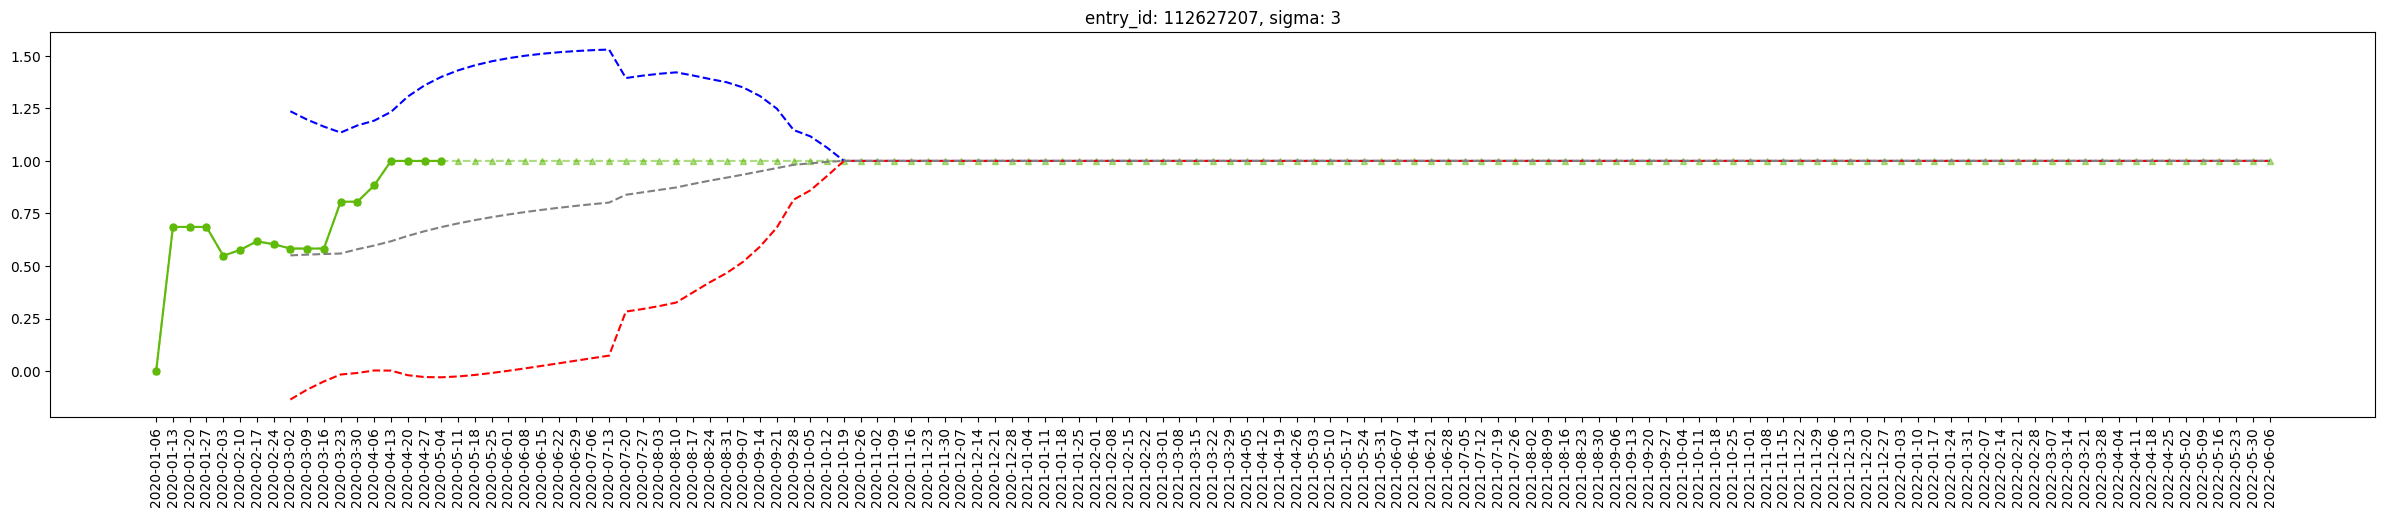

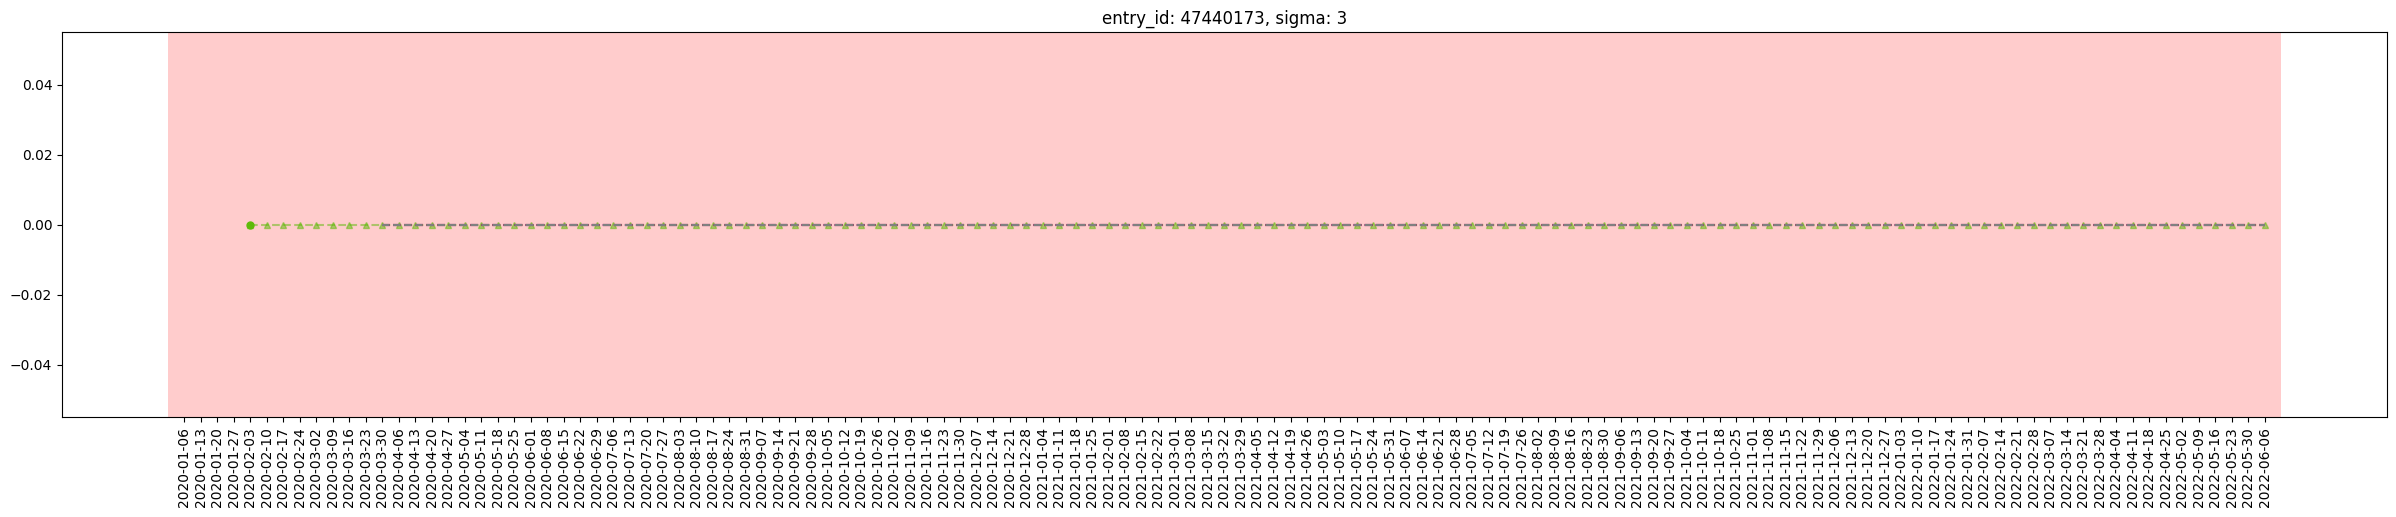

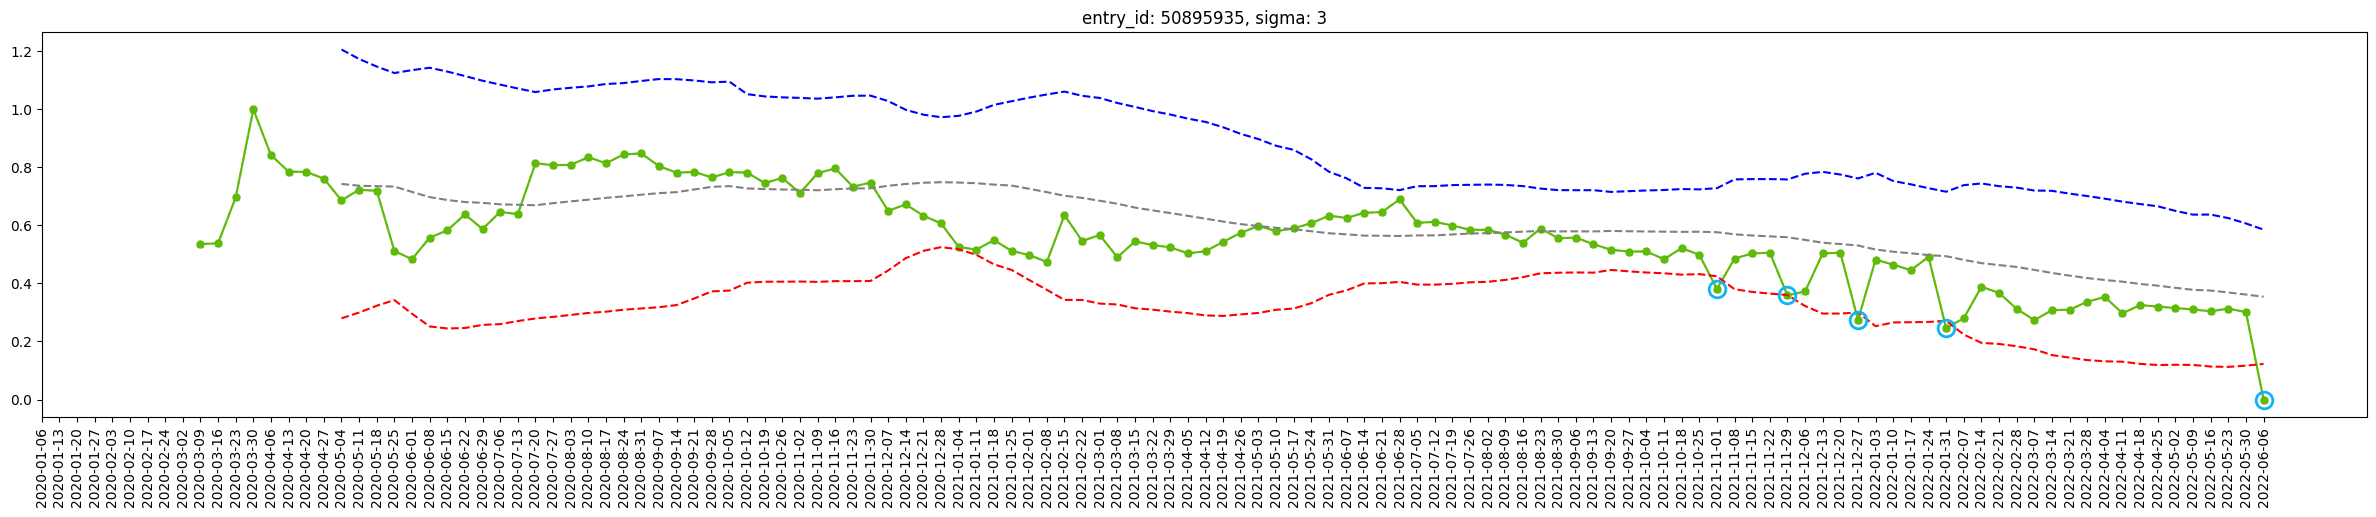

In [103]:
plt.style.use('default')
for sample in sample_entry[:50]:
    abnormalDetection_by_entry(df_pivot = df_stats_pivot, entry_id = sample, sigma = 3, display_plot = True)

# Compare

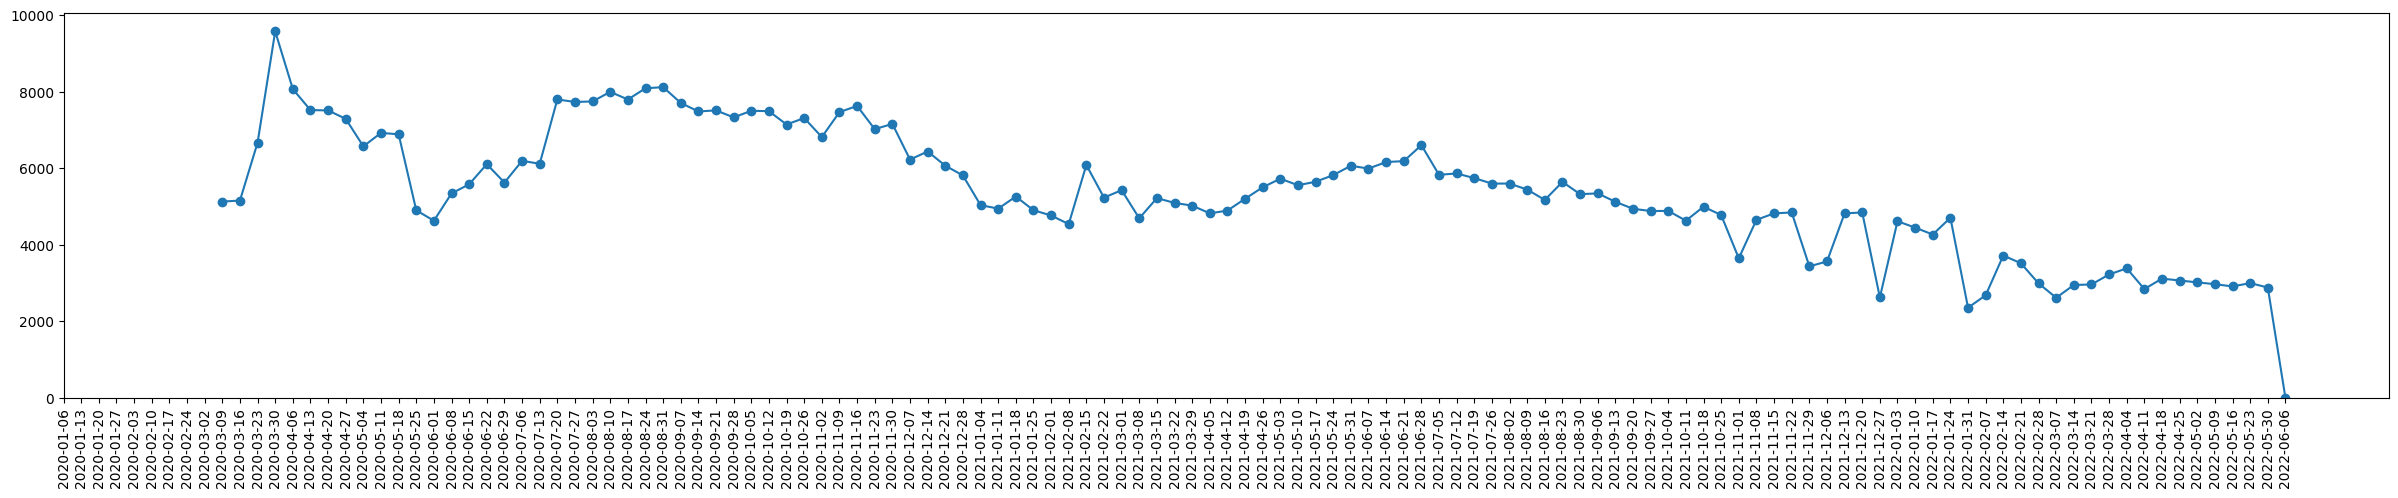

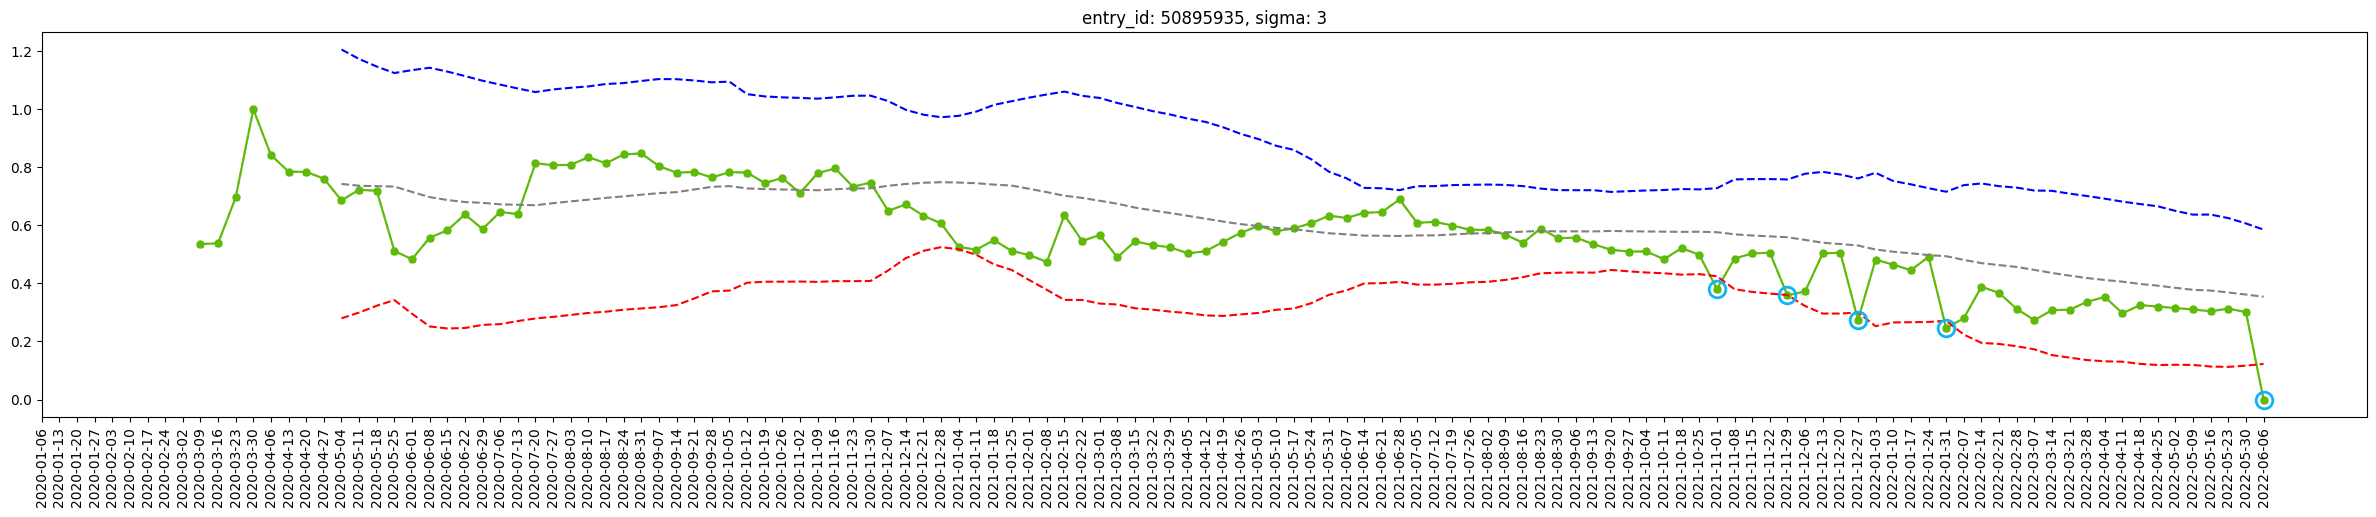

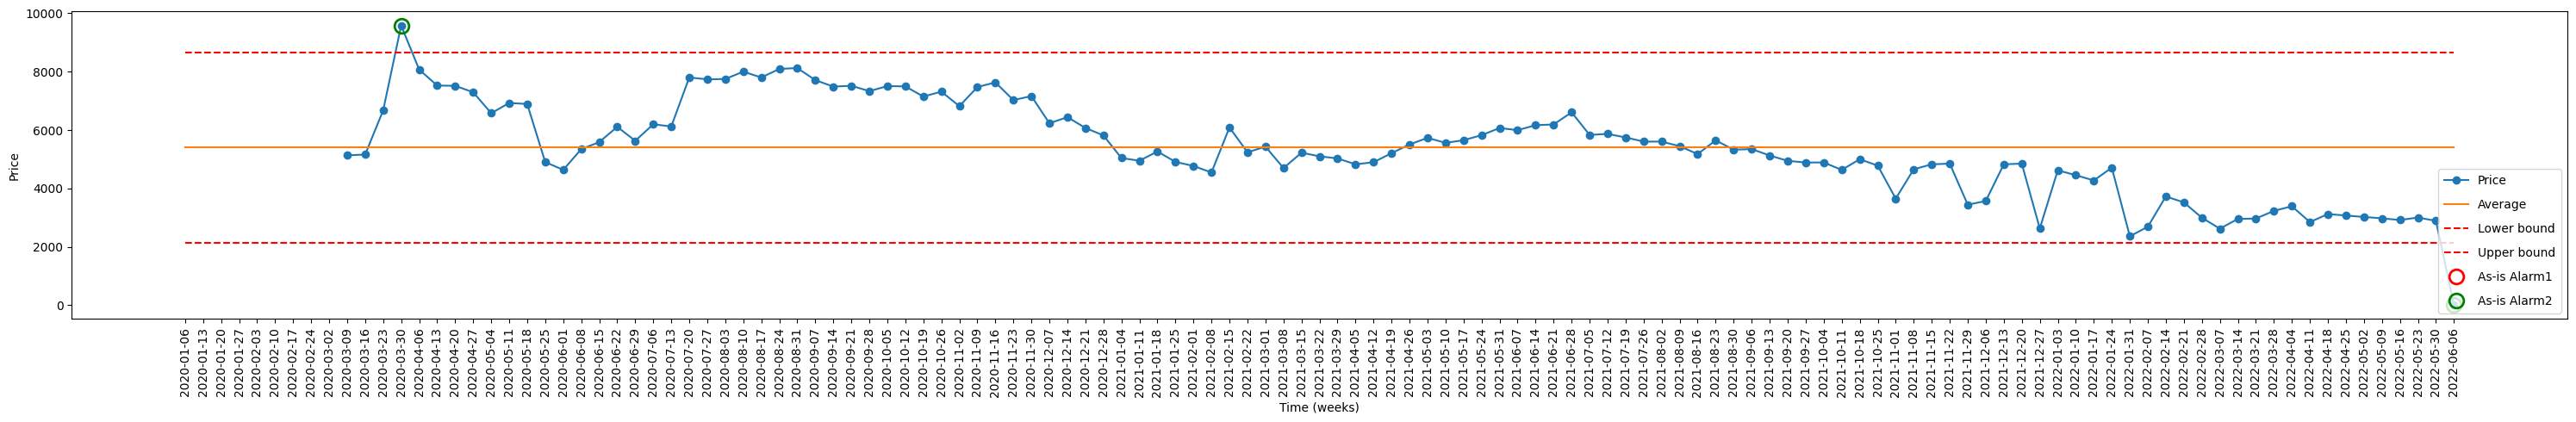

new Alarm 1 + 2    : [3650.25, 3440.0, 2627.5, 2359.25, 2.0]
as-is Alarm 1    : []
as-is Alarm 2    : [2.0, 9578.5714285714]
as-is Alarm 1 + 2: [2.0, 9578.5714285714]


In [104]:
def plot_original(df_pivot, entry_id):
    # Masking null_value
    sample_entry = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    x = sample_entry.date
    y = sample_entry.price_avg.astype(np.double)
    ymask = np.isfinite(y)
    
    plt.figure(figsize = (30, 5))
    plt.plot(x[ymask], y[ymask], linestyle = '-', marker = 'o')
    plt.xticks(x, rotation = 90)
    plt.ylim(bottom = 0)
    
    # axvspan with red color - find index of start & end point of null
    sample_entry = sample_entry.set_index('date')
    is_nan = sample_entry['price_avg'].isna()
    n_groups = is_nan.ne(is_nan.shift()).cumsum()
    
    if len(sample_entry[is_nan].groupby(n_groups).groups) > 1:
        gap_list = sample_entry[is_nan].groupby(n_groups).aggregate(
            lambda x: (
                x.index[0] + pd.DateOffset(days=-7),
                x.index[-1] + pd.DateOffset(days=+7)
            )
        )["price_avg"].values
    
        for gap in gap_list:
            plt.axvspan(gap[0], gap[1], facecolor='r', alpha=0.2)
    
    plt.show()
    
# As-is Logic VS To-be Logic - Change rate > 200 %, then raise an alarm
new_x_idx_lst, new_outlier_date, new_outlier_lst = abnormalDetection_by_entry(df_pivot = df_stats_pivot, entry_id = sample, sigma = 3, display_plot = False)

# As-is Logic VS To-be Logic - Change rate > 200 %, then raise an alarm
def compare_plot(df_pivot, entry_id, display_plot = False, plot_together = False):
    sample_entry = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    x = sample_entry['date']
    price = sample_entry['price_avg']
    
    '''
    As-is Alarm 1
    '''
    outlier_dic = {'alarm1': [], 'alarm2': []}
    
    alarm1_x_idx_lst = []
    for i in range(1, len(entry_df)):
        chg_rate = (price[i] - price[i-1]) / price[i-1]
        if chg_rate > 2:
            alarm1_x_idx_lst.append(i)
            outlier_dic['alarm1'].append(price[i]) 
    
    price_alarm1 = np.where(price.index.isin(alarm1_x_idx_lst), price, np.nan)

    '''
    As-is Alarm 2
    '''
    average = price.mean()
    threshold_min = average - 2 * price.std()
    threshold_max = average + 2 * price.std()
    if threshold_min < 0:
        threshold_min = 0
    
    alarm2_x_idx_lst = []
    for idx, point in enumerate(price, start = 0):
        if point < threshold_min or point > threshold_max:
            alarm2_x_idx_lst.append(idx)
            outlier_dic['alarm2'].append(point)
    
    price_alarm2 = np.where(price.index.isin(alarm2_x_idx_lst), price, np.nan)
    
    '''
    To-be Alarm 1 + 2
    '''
    new_price_alarm = np.where(price.index.isin(new_x_idx_lst), price, np.nan)
    
    if display_plot is True:
        plt.figure(figsize = (30, 5))
        
        plt.plot(x, price, marker= 'o')
        plt.plot([x.iat[0], x.iat[len(x)-1]], [average, average], '-')
        plt.plot([x.iat[0], x.iat[len(x)-1]], [threshold_min, threshold_min], '--', color='#ff0000')
        plt.plot([x.iat[0], x.iat[len(x)-1]], [threshold_max, threshold_max], '--', color='#ff0000')
        plt.plot(x, price_alarm1, 'o'
                 , markersize = 12, markerfacecolor = 'None', markeredgecolor = 'red', markeredgewidth = 2 )
        plt.plot(x, price_alarm2, 'o'
                 , markersize = 12, markerfacecolor = 'None', markeredgecolor = 'green', markeredgewidth = 2 )       
        
        if plot_together is True:
            plt.plot(x, new_price_alarm, 'o'
                     , markersize = 20, markerfacecolor = 'None', markeredgecolor = '#0EB4F7', markeredgewidth = 2 )
        plt.xticks(x, rotation = 90)
        plt.xlabel('Time (weeks)')
        plt.ylabel('Price')
        plt.legend(['Price', 'Average', 'Lower bound', 'Upper bound', 'As-is Alarm1', 'As-is Alarm2', 'New Alarm'], loc = 'lower right'
                  , borderpad = 0.5, labelspacing = 1)    
        plt.tight_layout()
        
        plt.show()
    
    alarm1_set = set(outlier_dic['alarm1'])
    alarm2_set = set(outlier_dic['alarm2'])
    unioned_set = alarm1_set.union(alarm2_set)
    
    return alarm1_set, alarm2_set, unioned_set

sample = 50895935
plot_original(df_pivot = df_stats_pivot, entry_id = sample)
x_idx_lst, outlier_dates, outlier_lst = abnormalDetection_by_entry(df_pivot = df_stats_pivot, entry_id = sample, sigma = 3, display_plot = True)
alarm1_set, alarm2_set, unioned_set = compare_plot(df_pivot = df_stats_pivot, entry_id = sample, display_plot = True, plot_together = False)

print(f'new Alarm 1 + 2    : {outlier_lst}')
print(f'as-is Alarm 1    : {sorted(list(alarm1_set))}')
print(f'as-is Alarm 2    : {sorted(list(alarm2_set))}')
print(f'as-is Alarm 1 + 2: {sorted(list(unioned_set))}')

In [70]:
def Raize_as_is_alarm(price_avg):    
    y = price_avg.astype(np.double)    
    avg = y.mean()
    threshold_min = avg - 2 * y.std()
    threshold_max = avg + 2 * y.std()
    if threshold_min < 0:
        threshold_min = 0

    df_y = y.to_frame(name = 'price')
    df_y['Alarm_as_is'] = np.where((y > threshold_max) | (y < threshold_min), 1, 0)
    
    Alarm_series = df_y['Alarm_as_is']
    return Alarm_series

df_ = df[['date', 'entry_id_', 'price_avg', 'price_avg_imputed']].copy()
Alarm_as_is_series = df_.groupby('entry_id_').progress_apply(lambda row : Raize_as_is_alarm(row.price_avg))
Alarm_as_is_df = Alarm_as_is_series.to_frame().reset_index(drop = True)
df_ = pd.concat([df_, Alarm_as_is_df], axis = 1)

100%|████████████████████████████████████████████| 2975/2975 [00:05<00:00, 583.25it/s]


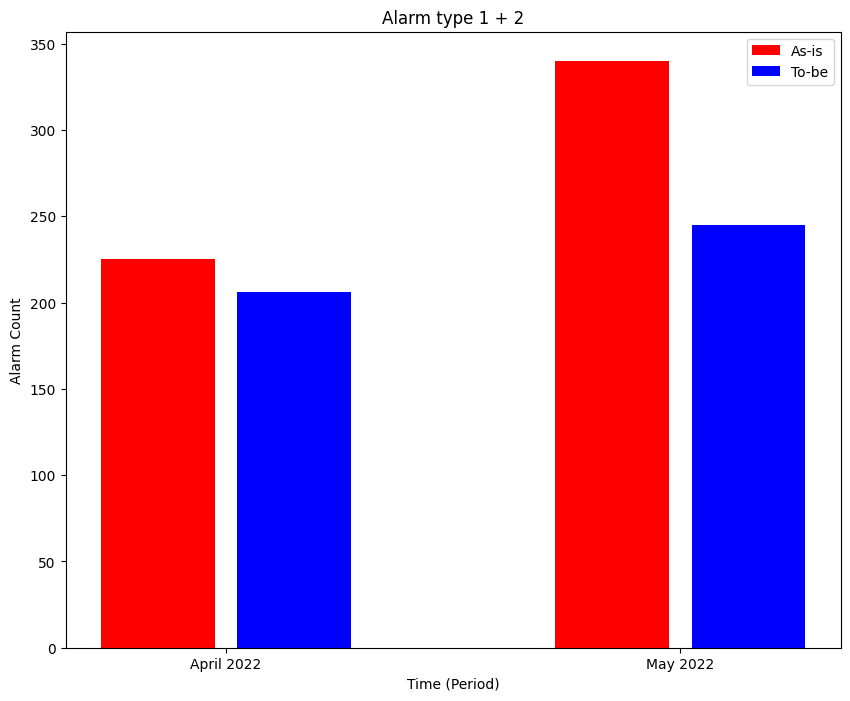

In [74]:
result_april_as_is = df_[(
    df_['date'] > pd.Timestamp('2022-04-01')) & (
    df_['date'] <= pd.Timestamp('2022-05-01')) & (
    df_['Alarm_as_is'] == 1)].groupby('entry_id_')['Alarm_as_is'].sum()

result_april = df_stats[(
    df_stats.index > pd.Timestamp('2022-04-01')) & (
    df_stats.index <= pd.Timestamp('2022-05-01')) & (
    df_stats['Alarm'] == 1)].groupby('entry_id_')['Alarm'].sum()

result_may_as_is = df_[(
    df_['date'] > pd.Timestamp('2022-05-01')) & (
    df_['date'] <= pd.Timestamp('2022-05-31')) & (
    df_['Alarm_as_is'] == 1)].groupby('entry_id_')['Alarm_as_is'].sum()

result_may = df_stats[(
    df_stats.index > pd.Timestamp('2022-05-01')) & (
    df_stats.index <= pd.Timestamp('2022-05-31')) & (
    df_stats['Alarm'] == 1)].groupby('entry_id_')['Alarm'].sum()

x = np.arange(2)
period = ['April 2022', 'May 2022']
asis = [result_april_as_is.sum(), result_may_as_is.sum()]
tobe = [result_april.sum(), result_may.sum()]

plt.figure(figsize = (10,8))
plt.bar(x, asis, color = 'red', width = 0.25, label = 'As-is')
plt.bar(x+0.3, tobe, color = 'blue', width = 0.25, label = 'To-be')
plt.xticks(x+0.15, period)
plt.legend()
plt.xlabel('Time (Period)')
plt.ylabel('Alarm Count')
plt.title('Alarm type 1 + 2')
plt.show()